# LightGBM
### Parameters:
System:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**
    * **perception**
    * **speed** (*land speed*)
        * **other speeds**: fly, climb, swim
    * **num immunities**
    * **resistances**: fire, cold, electricity, acid, piercing, slashing, physical, bludgeoning, mental, poison, all-damage
    * **weaknesses**: cold-iron, good, fire, cold, area-damage, splash-damage, evil, slashing
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

Items
* **items**
    * **melee**
    * **ranged**
    * **spells nr**

### Prediction: *level*

## Loading data

In [1]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
characteristics = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
    "perception",
    "fortitude",
    "reflex",
    "will",
    "focus",
    "land_speed",
    "num_immunities",
    "fly",
    "swim",
    "climb",
    "fire_resistance",
    "cold_resistance",
    "electricity_resistance",
    "acid_resistance",
    "piercing_resistance",
    "slashing_resistance",
    "physical_resistance",
    "bludgeoning_resistance",
    "mental_resistance",
    "poison_resistance",
    "all-damage_resistance",
    "cold-iron_weakness",
    "good_weakness",
    "fire_weakness",
    "cold_weakness",
    "area-damage_weakness",
    "splash-damage_weakness",
    "evil_weakness",
    "slashing_weakness",
    "melee",
    "ranged",
    "spells",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=characteristics,
)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 52 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   con                     1206 non-null   int64  
 1   wis                     1206 non-null   int64  
 2   fortitude               1206 non-null   int64  
 3   book                    1206 non-null   object 
 4   str                     1206 non-null   int64  
 5   int                     1206 non-null   int64  
 6   dex                     1206 non-null   int64  
 7   cha                     1206 non-null   int64  
 8   land_speed              1206 non-null   float64
 9   reflex                  1206 non-null   int64  
 10  ac                      1206 non-null   int64  
 11  will                    1206 non-null   int64  
 12  num_immunities          1206 non-null   int64  
 13  perception              1206 non-null   int64  
 14  level                   1206 non-null   

In [3]:
df.head()

,con,wis,fortitude,book,str,int,dex,cha,land_speed,reflex,...,spells_nr_lvl_4,spells_nr_lvl_5,spells_nr_lvl_6,spells_nr_lvl_7,spells_nr_lvl_8,spells_nr_lvl_9,melee_max_bonus,avg_melee_dmg,ranged_max_bonus,avg_ranged_dmg
0,5,2,22,Pathfinder Bestiary,7,1,2,1,30.0,19,...,0,0,0,0,0,0,23,22.0,0,0.0
1,5,2,21,Pathfinder Bestiary,9,-4,0,1,35.0,14,...,0,0,0,0,0,0,23,22.0,0,0.0
2,6,3,20,Pathfinder Bestiary,7,-4,3,-2,30.0,17,...,0,0,0,0,0,0,21,16.0,0,0.0
3,5,5,30,Pathfinder Bestiary,7,6,4,6,50.0,29,...,1,0,1,0,0,0,33,31.5,0,0.0
4,1,1,6,Pathfinder Bestiary,-5,-1,3,1,0.0,10,...,1,0,0,0,0,0,0,0.0,8,5.0


###### Level

In [4]:
y = df["level"]
y

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64

In [5]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [6]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,34
1,0,27
2,1,127
3,2,121
4,3,95
5,4,82
6,5,76
7,6,72
8,7,77
9,8,68


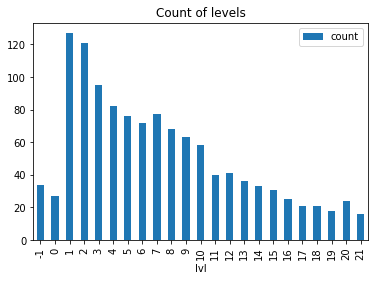

In [7]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [8]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [9]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [10]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [11]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [12]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 756
[LightGBM] [Info] Number of data points in the train set: 841, number of used features: 45
[LightGBM] [Info] Start training from score 6.966706
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 0.927292	valid_0's l1: 0.460853


In [13]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.93
RMSE: 0.96
MAE: 0.46


In [15]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Number of characteristics": [],
        "MSE": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "normal", len(X_test.columns), mse, rmse, mae]

In [16]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.12
RMSE test: 0.96


###### MAE by level

In [17]:
from training.results import plot_mae_by_level

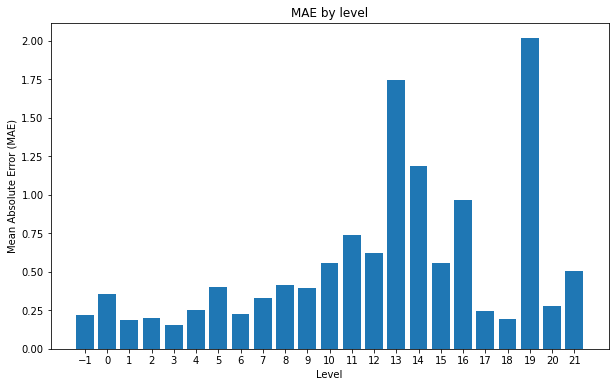

In [18]:
plot_mae_by_level(y_test, y_pred_test)

In [19]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions(["round", 0.33, 0.45], y_test, y_pred_test)

Normal:
MSE: 0.93
RMSE: 0.96

Round type: round
MSE: 0.96
RMSE: 0.98

Round type: 0.33
MSE: 0.91
RMSE: 0.95

Round type: 0.45
MSE: 0.93
RMSE: 0.96



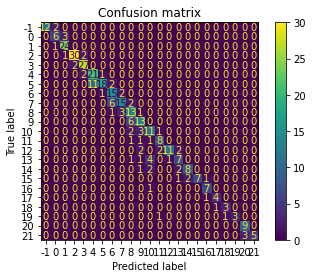

In [20]:
plot_confusion_matrix("round", y_pred_test, y_test)

#### Tuning

In [21]:
from training.results import assess_regression_model

In [22]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-03 20:12:23,859] A new study created in memory with name: no-name-22f33497-960a-4818-bc03-cb6bccdd07a1
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.145867 + 0.0367984
[200]	cv_agg's l2: 0.142435 + 0.0335063
[300]	cv_agg's l2: 0.142277 + 0.0322317


feature_fraction, val_score: 0.141949:   0%|                                                     | 0/7 [00:03<?, ?it/s]

[400]	cv_agg's l2: 0.142029 + 0.0323715
Early stopping, best iteration is:
[326]	cv_agg's l2: 0.141949 + 0.0321828


feature_fraction, val_score: 0.141949:  14%|######4                                      | 1/7 [00:03<00:18,  3.06s/it]

[100]	cv_agg's l2: 0.153477 + 0.0340435
[200]	cv_agg's l2: 0.150369 + 0.0338086
[300]	cv_agg's l2: 0.150324 + 0.0337079
[400]	cv_agg's l2: 0.150481 + 0.0337475


feature_fraction, val_score: 0.141949:  29%|############8                                | 2/7 [00:07<00:18,  3.71s/it]

Early stopping, best iteration is:
[326]	cv_agg's l2: 0.141949 + 0.0321828
[100]	cv_agg's l2: 0.148047 + 0.0331359
[200]	cv_agg's l2: 0.145093 + 0.0325521
[300]	cv_agg's l2: 0.144854 + 0.0326871
[400]	cv_agg's l2: 0.144313 + 0.0325655


feature_fraction, val_score: 0.141949:  43%|###################2                         | 3/7 [00:12<00:16,  4.23s/it]

Early stopping, best iteration is:
[326]	cv_agg's l2: 0.141949 + 0.0321828
[100]	cv_agg's l2: 0.147055 + 0.042925
[200]	cv_agg's l2: 0.143156 + 0.0396987
[300]	cv_agg's l2: 0.141538 + 0.0384299
[400]	cv_agg's l2: 0.141634 + 0.0385567


feature_fraction, val_score: 0.141416:  57%|#########################7                   | 4/7 [00:17<00:14,  4.88s/it]

Early stopping, best iteration is:
[371]	cv_agg's l2: 0.141416 + 0.0384599
[100]	cv_agg's l2: 0.145991 + 0.0336441
[200]	cv_agg's l2: 0.142971 + 0.0334422
[300]	cv_agg's l2: 0.142787 + 0.0333699
[400]	cv_agg's l2: 0.142624 + 0.0336367


feature_fraction, val_score: 0.141416:  71%|################################1            | 5/7 [00:24<00:11,  5.65s/it]

Early stopping, best iteration is:
[371]	cv_agg's l2: 0.141416 + 0.0384599
[100]	cv_agg's l2: 0.150115 + 0.0377139
[200]	cv_agg's l2: 0.146765 + 0.0350294
[300]	cv_agg's l2: 0.146379 + 0.0352867
[400]	cv_agg's l2: 0.145778 + 0.0349132


feature_fraction, val_score: 0.141416:  86%|######################################5      | 6/7 [00:30<00:05,  5.75s/it]

Early stopping, best iteration is:
[371]	cv_agg's l2: 0.141416 + 0.0384599
[100]	cv_agg's l2: 0.144025 + 0.0288164
[200]	cv_agg's l2: 0.141649 + 0.0280589
[300]	cv_agg's l2: 0.14031 + 0.0267642
[400]	cv_agg's l2: 0.140381 + 0.0262626


feature_fraction, val_score: 0.140015: 100%|#############################################| 7/7 [00:37<00:00,  5.33s/it]


Early stopping, best iteration is:
[363]	cv_agg's l2: 0.140015 + 0.0264199


num_leaves, val_score: 0.140015:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.144025 + 0.0288164
[200]	cv_agg's l2: 0.141649 + 0.0280589
[300]	cv_agg's l2: 0.14031 + 0.0267642
[400]	cv_agg's l2: 0.140381 + 0.0262626


num_leaves, val_score: 0.140015:   5%|##5                                               | 1/20 [00:06<01:58,  6.24s/it]

Early stopping, best iteration is:
[363]	cv_agg's l2: 0.140015 + 0.0264199
[100]	cv_agg's l2: 0.144025 + 0.0288164
[200]	cv_agg's l2: 0.141649 + 0.0280589
[300]	cv_agg's l2: 0.14031 + 0.0267642
[400]	cv_agg's l2: 0.140381 + 0.0262626


num_leaves, val_score: 0.140015:  10%|#####                                             | 2/20 [00:12<01:54,  6.35s/it]

Early stopping, best iteration is:
[363]	cv_agg's l2: 0.140015 + 0.0264199
[100]	cv_agg's l2: 0.144025 + 0.0288164
[200]	cv_agg's l2: 0.141649 + 0.0280589
[300]	cv_agg's l2: 0.14031 + 0.0267642
[400]	cv_agg's l2: 0.140381 + 0.0262626


num_leaves, val_score: 0.140015:  15%|#######5                                          | 3/20 [00:18<01:46,  6.26s/it]

Early stopping, best iteration is:
[363]	cv_agg's l2: 0.140015 + 0.0264199
[100]	cv_agg's l2: 0.144025 + 0.0288164
[200]	cv_agg's l2: 0.141649 + 0.0280589
[300]	cv_agg's l2: 0.14031 + 0.0267642
[400]	cv_agg's l2: 0.140381 + 0.0262626


num_leaves, val_score: 0.140015:  20%|##########                                        | 4/20 [00:26<01:50,  6.89s/it]

Early stopping, best iteration is:
[363]	cv_agg's l2: 0.140015 + 0.0264199
[100]	cv_agg's l2: 0.144025 + 0.0288164
[200]	cv_agg's l2: 0.141649 + 0.0280589
[300]	cv_agg's l2: 0.14031 + 0.0267642
[400]	cv_agg's l2: 0.140381 + 0.0262626


num_leaves, val_score: 0.140015:  25%|############5                                     | 5/20 [00:33<01:41,  6.74s/it]

Early stopping, best iteration is:
[363]	cv_agg's l2: 0.140015 + 0.0264199
[100]	cv_agg's l2: 0.144025 + 0.0288164
[200]	cv_agg's l2: 0.141649 + 0.0280589
[300]	cv_agg's l2: 0.14031 + 0.0267642
[400]	cv_agg's l2: 0.140381 + 0.0262626


num_leaves, val_score: 0.140015:  30%|###############                                   | 6/20 [00:39<01:31,  6.53s/it]

Early stopping, best iteration is:
[363]	cv_agg's l2: 0.140015 + 0.0264199
[100]	cv_agg's l2: 0.144025 + 0.0288164
[200]	cv_agg's l2: 0.141649 + 0.0280589
[300]	cv_agg's l2: 0.14031 + 0.0267642
[400]	cv_agg's l2: 0.140381 + 0.0262626


num_leaves, val_score: 0.140015:  35%|#################5                                | 7/20 [00:46<01:27,  6.76s/it]

Early stopping, best iteration is:
[363]	cv_agg's l2: 0.140015 + 0.0264199
[100]	cv_agg's l2: 0.144025 + 0.0288164
[200]	cv_agg's l2: 0.141649 + 0.0280589
[300]	cv_agg's l2: 0.14031 + 0.0267642
[400]	cv_agg's l2: 0.140381 + 0.0262626


num_leaves, val_score: 0.140015:  40%|####################                              | 8/20 [00:53<01:20,  6.71s/it]

Early stopping, best iteration is:
[363]	cv_agg's l2: 0.140015 + 0.0264199
[100]	cv_agg's l2: 0.144025 + 0.0288164
[200]	cv_agg's l2: 0.141649 + 0.0280589
[300]	cv_agg's l2: 0.14031 + 0.0267642
[400]	cv_agg's l2: 0.140381 + 0.0262626


num_leaves, val_score: 0.140015:  45%|######################5                           | 9/20 [00:58<01:10,  6.40s/it]

Early stopping, best iteration is:
[363]	cv_agg's l2: 0.140015 + 0.0264199
[100]	cv_agg's l2: 0.144025 + 0.0288164
[200]	cv_agg's l2: 0.141649 + 0.0280589
[300]	cv_agg's l2: 0.14031 + 0.0267642
[400]	cv_agg's l2: 0.140381 + 0.0262626


num_leaves, val_score: 0.140015:  50%|########################5                        | 10/20 [01:05<01:05,  6.55s/it]

Early stopping, best iteration is:
[363]	cv_agg's l2: 0.140015 + 0.0264199
[100]	cv_agg's l2: 0.154137 + 0.0393863
[200]	cv_agg's l2: 0.14364 + 0.0367793
[300]	cv_agg's l2: 0.139298 + 0.0352731
[400]	cv_agg's l2: 0.137705 + 0.0349869
[500]	cv_agg's l2: 0.137004 + 0.0348346
[600]	cv_agg's l2: 0.136455 + 0.0344713


num_leaves, val_score: 0.136425:  55%|##########################9                      | 11/20 [01:10<00:53,  5.95s/it]

Early stopping, best iteration is:
[592]	cv_agg's l2: 0.136425 + 0.0344298
[100]	cv_agg's l2: 0.323247 + 0.0683779
[200]	cv_agg's l2: 0.288811 + 0.0630817
[300]	cv_agg's l2: 0.27844 + 0.0596602
[400]	cv_agg's l2: 0.270947 + 0.0586625
[500]	cv_agg's l2: 0.265428 + 0.0574742
[600]	cv_agg's l2: 0.260686 + 0.0565867


num_leaves, val_score: 0.136425:  60%|#############################4                   | 12/20 [01:12<00:37,  4.68s/it]

Early stopping, best iteration is:
[592]	cv_agg's l2: 0.136425 + 0.0344298
[100]	cv_agg's l2: 0.172382 + 0.0344846
[200]	cv_agg's l2: 0.158806 + 0.0319872
[300]	cv_agg's l2: 0.154311 + 0.0315473
[400]	cv_agg's l2: 0.152033 + 0.0311845
[500]	cv_agg's l2: 0.151081 + 0.0309122
[600]	cv_agg's l2: 0.148979 + 0.0304926


num_leaves, val_score: 0.136425:  65%|###############################8                 | 13/20 [01:15<00:30,  4.41s/it]

Early stopping, best iteration is:
[592]	cv_agg's l2: 0.136425 + 0.0344298
[100]	cv_agg's l2: 0.144025 + 0.0288164
[200]	cv_agg's l2: 0.141649 + 0.0280589
[300]	cv_agg's l2: 0.14031 + 0.0267642
[400]	cv_agg's l2: 0.140381 + 0.0262626
[500]	cv_agg's l2: 0.140722 + 0.0263476
[600]	cv_agg's l2: 0.140831 + 0.0262944


num_leaves, val_score: 0.136425:  70%|##################################3              | 14/20 [01:24<00:35,  5.84s/it]

Early stopping, best iteration is:
[592]	cv_agg's l2: 0.136425 + 0.0344298
[100]	cv_agg's l2: 0.144025 + 0.0288164
[200]	cv_agg's l2: 0.141649 + 0.0280589
[300]	cv_agg's l2: 0.14031 + 0.0267642
[400]	cv_agg's l2: 0.140381 + 0.0262626
[500]	cv_agg's l2: 0.140722 + 0.0263476
[600]	cv_agg's l2: 0.140831 + 0.0262944


num_leaves, val_score: 0.136425:  75%|####################################7            | 15/20 [01:34<00:34,  6.93s/it]

Early stopping, best iteration is:
[592]	cv_agg's l2: 0.136425 + 0.0344298
[100]	cv_agg's l2: 0.144025 + 0.0288164
[200]	cv_agg's l2: 0.141649 + 0.0280589
[300]	cv_agg's l2: 0.14031 + 0.0267642
[400]	cv_agg's l2: 0.140381 + 0.0262626
[500]	cv_agg's l2: 0.140722 + 0.0263476
[600]	cv_agg's l2: 0.140831 + 0.0262944


num_leaves, val_score: 0.136425:  80%|#######################################2         | 16/20 [01:43<00:30,  7.58s/it]

Early stopping, best iteration is:
[592]	cv_agg's l2: 0.136425 + 0.0344298
[100]	cv_agg's l2: 0.144025 + 0.0288164
[200]	cv_agg's l2: 0.141649 + 0.0280589
[300]	cv_agg's l2: 0.14031 + 0.0267642
[400]	cv_agg's l2: 0.140381 + 0.0262626
[500]	cv_agg's l2: 0.140722 + 0.0263476
[600]	cv_agg's l2: 0.140831 + 0.0262944


num_leaves, val_score: 0.136425:  85%|#########################################6       | 17/20 [01:52<00:23,  7.85s/it]

Early stopping, best iteration is:
[592]	cv_agg's l2: 0.136425 + 0.0344298
[100]	cv_agg's l2: 0.144025 + 0.0288164
[200]	cv_agg's l2: 0.141649 + 0.0280589
[300]	cv_agg's l2: 0.14031 + 0.0267642
[400]	cv_agg's l2: 0.140381 + 0.0262626
[500]	cv_agg's l2: 0.140722 + 0.0263476
[600]	cv_agg's l2: 0.140831 + 0.0262944


num_leaves, val_score: 0.136425:  90%|############################################1    | 18/20 [01:57<00:14,  7.00s/it]

Early stopping, best iteration is:
[592]	cv_agg's l2: 0.136425 + 0.0344298
[100]	cv_agg's l2: 0.144025 + 0.0288164
[200]	cv_agg's l2: 0.141649 + 0.0280589
[300]	cv_agg's l2: 0.14031 + 0.0267642
[400]	cv_agg's l2: 0.140381 + 0.0262626
[500]	cv_agg's l2: 0.140722 + 0.0263476
[600]	cv_agg's l2: 0.140831 + 0.0262944


num_leaves, val_score: 0.136425:  95%|##############################################5  | 19/20 [02:02<00:06,  6.48s/it]

Early stopping, best iteration is:
[592]	cv_agg's l2: 0.136425 + 0.0344298
[100]	cv_agg's l2: 0.144025 + 0.0288164
[200]	cv_agg's l2: 0.141649 + 0.0280589
[300]	cv_agg's l2: 0.14031 + 0.0267642
[400]	cv_agg's l2: 0.140381 + 0.0262626
[500]	cv_agg's l2: 0.140722 + 0.0263476
[600]	cv_agg's l2: 0.140831 + 0.0262944


num_leaves, val_score: 0.136425: 100%|#################################################| 20/20 [02:08<00:00,  6.43s/it]


Early stopping, best iteration is:
[592]	cv_agg's l2: 0.136425 + 0.0344298


bagging, val_score: 0.136425:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.152101 + 0.035258
[200]	cv_agg's l2: 0.142315 + 0.0353031
[300]	cv_agg's l2: 0.140431 + 0.035096
[400]	cv_agg's l2: 0.139425 + 0.0344595
[500]	cv_agg's l2: 0.139522 + 0.034469
[600]	cv_agg's l2: 0.139273 + 0.0338498


bagging, val_score: 0.136425:  10%|#####3                                               | 1/10 [00:03<00:27,  3.01s/it]

Early stopping, best iteration is:
[592]	cv_agg's l2: 0.136425 + 0.0344298
[100]	cv_agg's l2: 0.153749 + 0.0329788
[200]	cv_agg's l2: 0.143808 + 0.0310386
[300]	cv_agg's l2: 0.139898 + 0.0297433
[400]	cv_agg's l2: 0.137798 + 0.0286977
[500]	cv_agg's l2: 0.136935 + 0.0285099
[600]	cv_agg's l2: 0.136523 + 0.0281521


bagging, val_score: 0.136425:  20%|##########6                                          | 2/10 [00:06<00:24,  3.06s/it]

Early stopping, best iteration is:
[592]	cv_agg's l2: 0.136425 + 0.0344298
[100]	cv_agg's l2: 0.147902 + 0.0372088
[200]	cv_agg's l2: 0.138767 + 0.0343593
[300]	cv_agg's l2: 0.136296 + 0.0334686
[400]	cv_agg's l2: 0.134845 + 0.0317551
[500]	cv_agg's l2: 0.134427 + 0.0313508
[600]	cv_agg's l2: 0.133927 + 0.030819


bagging, val_score: 0.133921:  30%|###############9                                     | 3/10 [00:08<00:19,  2.81s/it]

Early stopping, best iteration is:
[599]	cv_agg's l2: 0.133921 + 0.0308293
[100]	cv_agg's l2: 0.15154 + 0.0364094
[200]	cv_agg's l2: 0.140715 + 0.0340993
[300]	cv_agg's l2: 0.138024 + 0.0323559
[400]	cv_agg's l2: 0.136439 + 0.0313795
[500]	cv_agg's l2: 0.136119 + 0.0309207
[600]	cv_agg's l2: 0.135915 + 0.0299235


bagging, val_score: 0.133921:  40%|#####################2                               | 4/10 [00:11<00:16,  2.79s/it]

Early stopping, best iteration is:
[599]	cv_agg's l2: 0.133921 + 0.0308293
[100]	cv_agg's l2: 0.151343 + 0.0341009
[200]	cv_agg's l2: 0.142072 + 0.0315187
[300]	cv_agg's l2: 0.13947 + 0.0302907
[400]	cv_agg's l2: 0.137895 + 0.0298109
[500]	cv_agg's l2: 0.137213 + 0.029718
[600]	cv_agg's l2: 0.137227 + 0.0294892


bagging, val_score: 0.133921:  50%|##########################5                          | 5/10 [00:13<00:13,  2.67s/it]

Early stopping, best iteration is:
[599]	cv_agg's l2: 0.133921 + 0.0308293
[100]	cv_agg's l2: 0.151939 + 0.0343848
[200]	cv_agg's l2: 0.14292 + 0.0345348
[300]	cv_agg's l2: 0.139522 + 0.0332366
[400]	cv_agg's l2: 0.13878 + 0.0330673
[500]	cv_agg's l2: 0.138215 + 0.0323107
[600]	cv_agg's l2: 0.137205 + 0.0320006


bagging, val_score: 0.133921:  60%|###############################8                     | 6/10 [00:16<00:10,  2.65s/it]

Early stopping, best iteration is:
[599]	cv_agg's l2: 0.133921 + 0.0308293
[100]	cv_agg's l2: 0.152466 + 0.0257753
[200]	cv_agg's l2: 0.144747 + 0.0246247
[300]	cv_agg's l2: 0.143663 + 0.022766
[400]	cv_agg's l2: 0.142264 + 0.022459
[500]	cv_agg's l2: 0.141605 + 0.0218792
[600]	cv_agg's l2: 0.141667 + 0.0223363


bagging, val_score: 0.133921:  70%|#####################################                | 7/10 [00:19<00:08,  2.75s/it]

Early stopping, best iteration is:
[599]	cv_agg's l2: 0.133921 + 0.0308293
[100]	cv_agg's l2: 0.202701 + 0.0366787
[200]	cv_agg's l2: 0.190524 + 0.0373225
[300]	cv_agg's l2: 0.186107 + 0.0321128
[400]	cv_agg's l2: 0.182491 + 0.028404
[500]	cv_agg's l2: 0.182909 + 0.0261395
[600]	cv_agg's l2: 0.183836 + 0.0283425


bagging, val_score: 0.133921:  80%|##########################################4          | 8/10 [00:21<00:05,  2.67s/it]

Early stopping, best iteration is:
[599]	cv_agg's l2: 0.133921 + 0.0308293
[100]	cv_agg's l2: 0.154151 + 0.0336309
[200]	cv_agg's l2: 0.145831 + 0.0303516
[300]	cv_agg's l2: 0.142581 + 0.0291404
[400]	cv_agg's l2: 0.14165 + 0.0293117
[500]	cv_agg's l2: 0.140744 + 0.0291569
[600]	cv_agg's l2: 0.140865 + 0.0293831


bagging, val_score: 0.133921:  90%|###############################################7     | 9/10 [00:24<00:02,  2.68s/it]

Early stopping, best iteration is:
[599]	cv_agg's l2: 0.133921 + 0.0308293
[100]	cv_agg's l2: 0.161271 + 0.0363974
[200]	cv_agg's l2: 0.151064 + 0.0329336
[300]	cv_agg's l2: 0.148046 + 0.0322821
[400]	cv_agg's l2: 0.145468 + 0.0306644
[500]	cv_agg's l2: 0.145495 + 0.0307209
[600]	cv_agg's l2: 0.145871 + 0.0309271


bagging, val_score: 0.133921: 100%|####################################################| 10/10 [00:27<00:00,  2.72s/it]


Early stopping, best iteration is:
[599]	cv_agg's l2: 0.133921 + 0.0308293


feature_fraction_stage2, val_score: 0.133921:   0%|                                              | 0/3 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.149612 + 0.0383498
[200]	cv_agg's l2: 0.138822 + 0.0333488
[300]	cv_agg's l2: 0.136387 + 0.0315199
[400]	cv_agg's l2: 0.134647 + 0.0304492
[500]	cv_agg's l2: 0.133941 + 0.029562
[600]	cv_agg's l2: 0.133386 + 0.0292138


feature_fraction_stage2, val_score: 0.133386:  33%|############6                         | 1/3 [00:02<00:04,  2.47s/it]

[700]	cv_agg's l2: 0.133973 + 0.0292356
Early stopping, best iteration is:
[600]	cv_agg's l2: 0.133386 + 0.0292138
[100]	cv_agg's l2: 0.151757 + 0.0392379
[200]	cv_agg's l2: 0.145424 + 0.0381605
[300]	cv_agg's l2: 0.14314 + 0.0366785
[400]	cv_agg's l2: 0.141726 + 0.0363132
[500]	cv_agg's l2: 0.141642 + 0.0364613
[600]	cv_agg's l2: 0.141787 + 0.0361369


feature_fraction_stage2, val_score: 0.133386:  67%|#########################3            | 2/3 [00:04<00:02,  2.49s/it]

[700]	cv_agg's l2: 0.141429 + 0.0358091
Early stopping, best iteration is:
[600]	cv_agg's l2: 0.133386 + 0.0292138
[100]	cv_agg's l2: 0.148417 + 0.0358819
[200]	cv_agg's l2: 0.138285 + 0.0338875
[300]	cv_agg's l2: 0.135938 + 0.0326281
[400]	cv_agg's l2: 0.134766 + 0.0322894
[500]	cv_agg's l2: 0.133397 + 0.0316672
[600]	cv_agg's l2: 0.133317 + 0.0309136


feature_fraction_stage2, val_score: 0.133228: 100%|######################################| 3/3 [00:07<00:00,  2.48s/it]


[700]	cv_agg's l2: 0.133375 + 0.0310527
Early stopping, best iteration is:
[604]	cv_agg's l2: 0.133228 + 0.0308177


regularization_factors, val_score: 0.133228:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.148295 + 0.0338715
[200]	cv_agg's l2: 0.138761 + 0.0326224
[300]	cv_agg's l2: 0.135146 + 0.0322518
[400]	cv_agg's l2: 0.134409 + 0.0324974
[500]	cv_agg's l2: 0.134212 + 0.0325006
[600]	cv_agg's l2: 0.133873 + 0.0321239


regularization_factors, val_score: 0.133228:   5%|#9                                    | 1/20 [00:02<00:50,  2.65s/it]

[700]	cv_agg's l2: 0.133871 + 0.0322266
Early stopping, best iteration is:
[604]	cv_agg's l2: 0.133228 + 0.0308177
[100]	cv_agg's l2: 0.148519 + 0.0363756
[200]	cv_agg's l2: 0.140051 + 0.0349279
[300]	cv_agg's l2: 0.137185 + 0.0341639
[400]	cv_agg's l2: 0.1363 + 0.0343746
[500]	cv_agg's l2: 0.136213 + 0.033861
[600]	cv_agg's l2: 0.135881 + 0.0337592


regularization_factors, val_score: 0.133228:  10%|###8                                  | 2/20 [00:05<00:47,  2.63s/it]

[700]	cv_agg's l2: 0.136154 + 0.0335573
Early stopping, best iteration is:
[604]	cv_agg's l2: 0.133228 + 0.0308177
[100]	cv_agg's l2: 0.147868 + 0.0360382
[200]	cv_agg's l2: 0.139591 + 0.0355566
[300]	cv_agg's l2: 0.137006 + 0.035048
[400]	cv_agg's l2: 0.135971 + 0.0346566
[500]	cv_agg's l2: 0.135672 + 0.0344692
[600]	cv_agg's l2: 0.135649 + 0.0341015


regularization_factors, val_score: 0.133228:  15%|#####7                                | 3/20 [00:07<00:45,  2.66s/it]

[700]	cv_agg's l2: 0.13555 + 0.0341629
Early stopping, best iteration is:
[604]	cv_agg's l2: 0.133228 + 0.0308177
[100]	cv_agg's l2: 0.149124 + 0.037594
[200]	cv_agg's l2: 0.140818 + 0.03546
[300]	cv_agg's l2: 0.13806 + 0.0358039
[400]	cv_agg's l2: 0.137091 + 0.0353085
[500]	cv_agg's l2: 0.136972 + 0.0354078
[600]	cv_agg's l2: 0.13672 + 0.0348152


regularization_factors, val_score: 0.133228:  20%|#######6                              | 4/20 [00:10<00:44,  2.76s/it]

[700]	cv_agg's l2: 0.136719 + 0.0349546
Early stopping, best iteration is:
[604]	cv_agg's l2: 0.133228 + 0.0308177
[100]	cv_agg's l2: 0.148417 + 0.0358819
[200]	cv_agg's l2: 0.138559 + 0.0341146
[300]	cv_agg's l2: 0.136283 + 0.0329125
[400]	cv_agg's l2: 0.135144 + 0.0325827
[500]	cv_agg's l2: 0.133872 + 0.0318997
[600]	cv_agg's l2: 0.133696 + 0.0310287


regularization_factors, val_score: 0.133228:  25%|#########5                            | 5/20 [00:13<00:41,  2.73s/it]

[700]	cv_agg's l2: 0.133715 + 0.0313195
Early stopping, best iteration is:
[604]	cv_agg's l2: 0.133228 + 0.0308177
[100]	cv_agg's l2: 0.148417 + 0.0358819
[200]	cv_agg's l2: 0.138285 + 0.0338875
[300]	cv_agg's l2: 0.135938 + 0.0326281
[400]	cv_agg's l2: 0.134766 + 0.0322894
[500]	cv_agg's l2: 0.133397 + 0.0316672
[600]	cv_agg's l2: 0.133317 + 0.0309136


regularization_factors, val_score: 0.133222:  30%|###########4                          | 6/20 [00:16<00:40,  2.88s/it]

[700]	cv_agg's l2: 0.133398 + 0.031084
Early stopping, best iteration is:
[604]	cv_agg's l2: 0.133222 + 0.0308104
[100]	cv_agg's l2: 0.148417 + 0.0358819
[200]	cv_agg's l2: 0.138285 + 0.0338875
[300]	cv_agg's l2: 0.135938 + 0.0326281
[400]	cv_agg's l2: 0.134766 + 0.0322894
[500]	cv_agg's l2: 0.133397 + 0.0316672
[600]	cv_agg's l2: 0.133317 + 0.0309136


regularization_factors, val_score: 0.133222:  35%|#############3                        | 7/20 [00:20<00:39,  3.06s/it]

[700]	cv_agg's l2: 0.133364 + 0.0310382
Early stopping, best iteration is:
[604]	cv_agg's l2: 0.133222 + 0.0308104
[100]	cv_agg's l2: 0.148417 + 0.0358819
[200]	cv_agg's l2: 0.138285 + 0.0338875
[300]	cv_agg's l2: 0.135938 + 0.0326281
[400]	cv_agg's l2: 0.134766 + 0.0322894
[500]	cv_agg's l2: 0.133397 + 0.0316672
[600]	cv_agg's l2: 0.133317 + 0.0309136


regularization_factors, val_score: 0.133222:  40%|###############2                      | 8/20 [00:23<00:38,  3.23s/it]

[700]	cv_agg's l2: 0.133364 + 0.0310382
Early stopping, best iteration is:
[604]	cv_agg's l2: 0.133222 + 0.0308104
[100]	cv_agg's l2: 0.148417 + 0.0358819
[200]	cv_agg's l2: 0.138285 + 0.0338875
[300]	cv_agg's l2: 0.135938 + 0.0326281
[400]	cv_agg's l2: 0.134766 + 0.0322894
[500]	cv_agg's l2: 0.133397 + 0.0316672
[600]	cv_agg's l2: 0.133317 + 0.0309136


regularization_factors, val_score: 0.133222:  45%|#################1                    | 9/20 [00:27<00:35,  3.26s/it]

[700]	cv_agg's l2: 0.133364 + 0.0310382
Early stopping, best iteration is:
[604]	cv_agg's l2: 0.133222 + 0.0308104
[100]	cv_agg's l2: 0.148417 + 0.0358819
[200]	cv_agg's l2: 0.138285 + 0.0338875
[300]	cv_agg's l2: 0.135938 + 0.0326281
[400]	cv_agg's l2: 0.134766 + 0.0322894
[500]	cv_agg's l2: 0.133397 + 0.0316672
[600]	cv_agg's l2: 0.133317 + 0.0309136


regularization_factors, val_score: 0.133222:  50%|##################5                  | 10/20 [00:31<00:37,  3.75s/it]

[700]	cv_agg's l2: 0.133364 + 0.0310382
Early stopping, best iteration is:
[604]	cv_agg's l2: 0.133222 + 0.0308104
[100]	cv_agg's l2: 0.148417 + 0.0358819
[200]	cv_agg's l2: 0.138285 + 0.0338875
[300]	cv_agg's l2: 0.135938 + 0.0326281
[400]	cv_agg's l2: 0.134766 + 0.0322894
[500]	cv_agg's l2: 0.133397 + 0.0316672
[600]	cv_agg's l2: 0.133317 + 0.0309136


regularization_factors, val_score: 0.133222:  55%|####################3                | 11/20 [00:35<00:33,  3.67s/it]

[700]	cv_agg's l2: 0.133364 + 0.0310382
Early stopping, best iteration is:
[604]	cv_agg's l2: 0.133222 + 0.0308104
[100]	cv_agg's l2: 0.148417 + 0.0358819
[200]	cv_agg's l2: 0.138285 + 0.0338875
[300]	cv_agg's l2: 0.135938 + 0.0326281
[400]	cv_agg's l2: 0.134766 + 0.0322894
[500]	cv_agg's l2: 0.133397 + 0.0316672
[600]	cv_agg's l2: 0.133317 + 0.0309136


regularization_factors, val_score: 0.133222:  60%|######################2              | 12/20 [00:38<00:28,  3.61s/it]

[700]	cv_agg's l2: 0.133364 + 0.0310382
Early stopping, best iteration is:
[604]	cv_agg's l2: 0.133222 + 0.0308104
[100]	cv_agg's l2: 0.148417 + 0.0358819
[200]	cv_agg's l2: 0.138285 + 0.0338875
[300]	cv_agg's l2: 0.135938 + 0.0326281
[400]	cv_agg's l2: 0.134766 + 0.0322894
[500]	cv_agg's l2: 0.133397 + 0.0316672
[600]	cv_agg's l2: 0.133317 + 0.0309136


regularization_factors, val_score: 0.133222:  65%|########################             | 13/20 [00:42<00:24,  3.50s/it]

[700]	cv_agg's l2: 0.133364 + 0.0310382
Early stopping, best iteration is:
[604]	cv_agg's l2: 0.133222 + 0.0308104
[100]	cv_agg's l2: 0.148417 + 0.0358819
[200]	cv_agg's l2: 0.138285 + 0.0338875
[300]	cv_agg's l2: 0.135938 + 0.0326281
[400]	cv_agg's l2: 0.134766 + 0.0322894
[500]	cv_agg's l2: 0.133397 + 0.0316672
[600]	cv_agg's l2: 0.133317 + 0.0309136


regularization_factors, val_score: 0.133222:  70%|#########################9           | 14/20 [00:45<00:20,  3.38s/it]

[700]	cv_agg's l2: 0.133364 + 0.0310382
Early stopping, best iteration is:
[604]	cv_agg's l2: 0.133222 + 0.0308104
[100]	cv_agg's l2: 0.148417 + 0.0358819
[200]	cv_agg's l2: 0.138285 + 0.0338875
[300]	cv_agg's l2: 0.135938 + 0.0326281
[400]	cv_agg's l2: 0.134766 + 0.0322894
[500]	cv_agg's l2: 0.133397 + 0.0316672
[600]	cv_agg's l2: 0.133317 + 0.0309136


regularization_factors, val_score: 0.133222:  75%|###########################7         | 15/20 [00:48<00:16,  3.30s/it]

[700]	cv_agg's l2: 0.133364 + 0.0310382
Early stopping, best iteration is:
[604]	cv_agg's l2: 0.133222 + 0.0308104
[100]	cv_agg's l2: 0.148417 + 0.0358819
[200]	cv_agg's l2: 0.138285 + 0.0338875
[300]	cv_agg's l2: 0.135938 + 0.0326281
[400]	cv_agg's l2: 0.134766 + 0.0322894
[500]	cv_agg's l2: 0.133397 + 0.0316672
[600]	cv_agg's l2: 0.133317 + 0.0309136


regularization_factors, val_score: 0.133222:  80%|#############################6       | 16/20 [00:51<00:12,  3.17s/it]

[700]	cv_agg's l2: 0.133398 + 0.031084
Early stopping, best iteration is:
[604]	cv_agg's l2: 0.133222 + 0.0308104
[100]	cv_agg's l2: 0.148417 + 0.0358819
[200]	cv_agg's l2: 0.138285 + 0.0338875
[300]	cv_agg's l2: 0.135938 + 0.0326281
[400]	cv_agg's l2: 0.134766 + 0.0322894
[500]	cv_agg's l2: 0.133397 + 0.0316672
[600]	cv_agg's l2: 0.133317 + 0.0309136


regularization_factors, val_score: 0.133222:  85%|###############################4     | 17/20 [00:53<00:09,  3.05s/it]

[700]	cv_agg's l2: 0.133398 + 0.031084
Early stopping, best iteration is:
[604]	cv_agg's l2: 0.133222 + 0.0308104
[100]	cv_agg's l2: 0.148417 + 0.0358819
[200]	cv_agg's l2: 0.138285 + 0.0338875
[300]	cv_agg's l2: 0.135938 + 0.0326281
[400]	cv_agg's l2: 0.134773 + 0.0322795
[500]	cv_agg's l2: 0.133486 + 0.0315498
[600]	cv_agg's l2: 0.133423 + 0.0307717


regularization_factors, val_score: 0.133222:  90%|#################################3   | 18/20 [00:56<00:05,  2.97s/it]

[700]	cv_agg's l2: 0.13343 + 0.0310418
Early stopping, best iteration is:
[604]	cv_agg's l2: 0.133222 + 0.0308104
[100]	cv_agg's l2: 0.148417 + 0.0358819
[200]	cv_agg's l2: 0.138285 + 0.0338875
[300]	cv_agg's l2: 0.135938 + 0.0326281
[400]	cv_agg's l2: 0.134766 + 0.0322894
[500]	cv_agg's l2: 0.133397 + 0.0316672
[600]	cv_agg's l2: 0.133317 + 0.0309136


regularization_factors, val_score: 0.133222:  95%|###################################1 | 19/20 [00:59<00:02,  2.96s/it]

[700]	cv_agg's l2: 0.133398 + 0.031084
Early stopping, best iteration is:
[604]	cv_agg's l2: 0.133222 + 0.0308104
[100]	cv_agg's l2: 0.148417 + 0.0358819
[200]	cv_agg's l2: 0.138285 + 0.0338875
[300]	cv_agg's l2: 0.135938 + 0.0326281
[400]	cv_agg's l2: 0.134773 + 0.0322796
[500]	cv_agg's l2: 0.133486 + 0.0315498
[600]	cv_agg's l2: 0.133423 + 0.0307717


regularization_factors, val_score: 0.133222: 100%|#####################################| 20/20 [01:02<00:00,  3.12s/it]


[700]	cv_agg's l2: 0.13343 + 0.0310418
Early stopping, best iteration is:
[604]	cv_agg's l2: 0.133222 + 0.0308104


min_data_in_leaf, val_score: 0.133222:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.142425 + 0.0341719
[200]	cv_agg's l2: 0.136025 + 0.0333652
[300]	cv_agg's l2: 0.133383 + 0.0326373
[400]	cv_agg's l2: 0.132664 + 0.0330072
[500]	cv_agg's l2: 0.132151 + 0.0326047
[600]	cv_agg's l2: 0.131705 + 0.032613


min_data_in_leaf, val_score: 0.131567:  20%|#########                                    | 1/5 [00:03<00:12,  3.18s/it]

[700]	cv_agg's l2: 0.131727 + 0.0326676
Early stopping, best iteration is:
[624]	cv_agg's l2: 0.131567 + 0.0325387
[100]	cv_agg's l2: 0.172048 + 0.0422568
[200]	cv_agg's l2: 0.162671 + 0.041334
[300]	cv_agg's l2: 0.159369 + 0.0394088
[400]	cv_agg's l2: 0.157946 + 0.0392108
[500]	cv_agg's l2: 0.157227 + 0.0389404
[600]	cv_agg's l2: 0.156627 + 0.0393459


min_data_in_leaf, val_score: 0.131567:  40%|##################                           | 2/5 [00:05<00:08,  2.91s/it]

[700]	cv_agg's l2: 0.156847 + 0.0393044
Early stopping, best iteration is:
[624]	cv_agg's l2: 0.131567 + 0.0325387
[100]	cv_agg's l2: 0.22518 + 0.0513489
[200]	cv_agg's l2: 0.213526 + 0.0546965
[300]	cv_agg's l2: 0.208927 + 0.054035
[400]	cv_agg's l2: 0.207155 + 0.0548081
[500]	cv_agg's l2: 0.206881 + 0.056578
[600]	cv_agg's l2: 0.207038 + 0.0564358


min_data_in_leaf, val_score: 0.131567:  60%|###########################                  | 3/5 [00:08<00:05,  2.88s/it]

[700]	cv_agg's l2: 0.206985 + 0.0571493
Early stopping, best iteration is:
[624]	cv_agg's l2: 0.131567 + 0.0325387
[100]	cv_agg's l2: 0.733568 + 0.135573
[200]	cv_agg's l2: 0.692466 + 0.138869
[300]	cv_agg's l2: 0.670597 + 0.138319
[400]	cv_agg's l2: 0.66123 + 0.135444
[500]	cv_agg's l2: 0.653596 + 0.135935
[600]	cv_agg's l2: 0.64893 + 0.134499


min_data_in_leaf, val_score: 0.131567:  80%|####################################         | 4/5 [00:10<00:02,  2.56s/it]

[700]	cv_agg's l2: 0.643365 + 0.133589
Early stopping, best iteration is:
[624]	cv_agg's l2: 0.131567 + 0.0325387
[100]	cv_agg's l2: 0.134603 + 0.0339268
[200]	cv_agg's l2: 0.127224 + 0.0312683
[300]	cv_agg's l2: 0.125527 + 0.030792
[400]	cv_agg's l2: 0.125041 + 0.0305896
[500]	cv_agg's l2: 0.124222 + 0.0301974
[600]	cv_agg's l2: 0.123822 + 0.0300939
[700]	cv_agg's l2: 0.123683 + 0.0298544


min_data_in_leaf, val_score: 0.123668: 100%|#############################################| 5/5 [00:13<00:00,  2.79s/it]

[800]	cv_agg's l2: 0.123879 + 0.0300102
Early stopping, best iteration is:
[712]	cv_agg's l2: 0.123668 + 0.0298574


In [23]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.12366786631480009
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 7.943019834987324e-06
    lambda_l2: 3.9880240466372547e-07
    num_leaves: 10
    feature_fraction: 0.48000000000000004
    bagging_fraction: 0.9803017946091741
    bagging_freq: 1
    min_child_samples: 10


In [24]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [25]:
rmse, mse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.00
RMSE test: 0.63
MSE test: 0.40
MAE test: 0.37



In [26]:
results.loc[1] = [
    "chronological",
    "Optuna",
    len(X_test.columns),
    mse,
    rmse,
    mae,
]

###### MAE by level

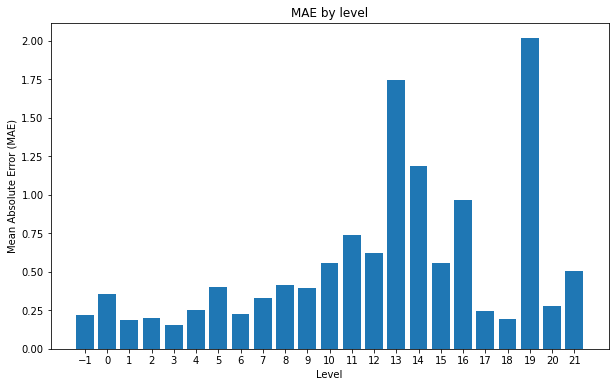

In [27]:
plot_mae_by_level(y_test, y_pred_test)

In [28]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.40
RMSE: 0.63

Round type: round
MSE: 0.45
RMSE: 0.67

Round type: 0.33
MSE: 0.40
RMSE: 0.63

Round type: 0.45
MSE: 0.43
RMSE: 0.65



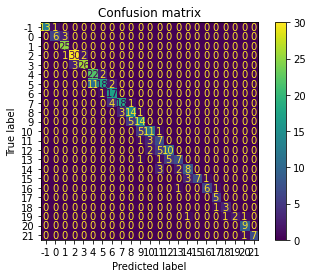

In [29]:
plot_confusion_matrix("round", predict, y_test)

## Random split

In [30]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 804
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 48
[LightGBM] [Info] Start training from score 7.162611
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[75]	valid_0's l2: 0.1379	valid_0's l1: 0.246737


In [31]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mse = mean_squared_error(y_test_random_split, y_pred_test)
rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.14
RMSE: 0.37
MAE: 0.25


In [33]:
results.loc[2] = ["random", "normal", len(X_test.columns), mse, rmse, mae]

###### MAE by level

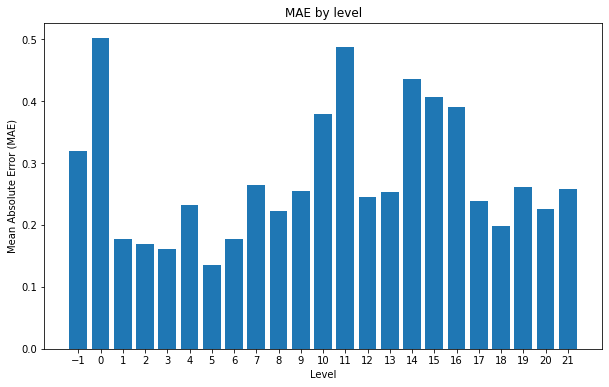

In [34]:
plot_mae_by_level(y_test_random_split, y_pred_test)

In [35]:
check_round_predictions(["round", 0.33, 0.45], y_test_random_split, y_pred_test)

Normal:
MSE: 0.14
RMSE: 0.37

Round type: round
MSE: 0.14
RMSE: 0.38

Round type: 0.33
MSE: 0.19
RMSE: 0.43

Round type: 0.45
MSE: 0.15
RMSE: 0.38



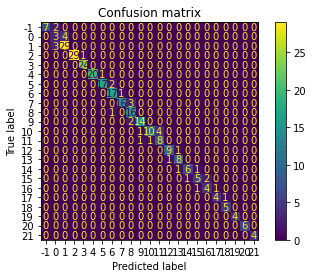

In [36]:
plot_confusion_matrix("round", y_pred_test, y_test_random_split)

### Tuning

In [37]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-03 20:17:12,128] A new study created in memory with name: no-name-b1b2bc5f-ed28-4857-b323-e260b1bd3bdf
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.166357 + 0.0480914
[200]	cv_agg's l2: 0.163345 + 0.046693
[300]	cv_agg's l2: 0.162648 + 0.0459699
[400]	cv_agg's l2: 0.162197 + 0.045978
[500]	cv_agg's l2: 0.161809 + 0.0454161
[600]	cv_agg's l2: 0.161727 + 0.04525
[700]	cv_agg's l2: 0.161429 + 0.0449114
[800]	cv_agg's l2: 0.161424 + 0.0448161
[900]	cv_agg's l2: 0.161353 + 0.0447303


feature_fraction, val_score: 0.161325:  14%|######4                                      | 1/7 [00:06<00:40,  6.79s/it]

Early stopping, best iteration is:
[876]	cv_agg's l2: 0.161325 + 0.0447077
[100]	cv_agg's l2: 0.165378 + 0.0455512
[200]	cv_agg's l2: 0.161328 + 0.0437072
[300]	cv_agg's l2: 0.160235 + 0.0424084
[400]	cv_agg's l2: 0.159959 + 0.0418961
[500]	cv_agg's l2: 0.159718 + 0.0417642
[600]	cv_agg's l2: 0.159657 + 0.0416622


feature_fraction, val_score: 0.159623:  29%|############8                                | 2/7 [00:11<00:26,  5.33s/it]

Early stopping, best iteration is:
[580]	cv_agg's l2: 0.159623 + 0.0416001
[100]	cv_agg's l2: 0.151925 + 0.0488314
[200]	cv_agg's l2: 0.147456 + 0.0467522
[300]	cv_agg's l2: 0.146983 + 0.0455379
[400]	cv_agg's l2: 0.146509 + 0.0451902
[500]	cv_agg's l2: 0.146359 + 0.0447353
[600]	cv_agg's l2: 0.146184 + 0.0445006
[700]	cv_agg's l2: 0.14613 + 0.0442065


feature_fraction, val_score: 0.146099:  43%|###################2                         | 3/7 [00:17<00:22,  5.66s/it]

Early stopping, best iteration is:
[662]	cv_agg's l2: 0.146099 + 0.0442605
[100]	cv_agg's l2: 0.173329 + 0.0421214
[200]	cv_agg's l2: 0.16885 + 0.0403238
[300]	cv_agg's l2: 0.16772 + 0.0395197
[400]	cv_agg's l2: 0.16718 + 0.0389958
[500]	cv_agg's l2: 0.167008 + 0.0387596
[600]	cv_agg's l2: 0.167107 + 0.038632
[700]	cv_agg's l2: 0.167086 + 0.0385921


feature_fraction, val_score: 0.146099:  57%|#########################7                   | 4/7 [00:22<00:16,  5.43s/it]

Early stopping, best iteration is:
[662]	cv_agg's l2: 0.146099 + 0.0442605
[100]	cv_agg's l2: 0.174998 + 0.0457681
[200]	cv_agg's l2: 0.170824 + 0.0441309
[300]	cv_agg's l2: 0.16946 + 0.0428201
[400]	cv_agg's l2: 0.168977 + 0.0424554
[500]	cv_agg's l2: 0.168729 + 0.0419182
[600]	cv_agg's l2: 0.168706 + 0.0416716
[700]	cv_agg's l2: 0.168588 + 0.0415007


feature_fraction, val_score: 0.146099:  71%|################################1            | 5/7 [00:27<00:10,  5.25s/it]

Early stopping, best iteration is:
[662]	cv_agg's l2: 0.146099 + 0.0442605
[100]	cv_agg's l2: 0.145309 + 0.0415008
[200]	cv_agg's l2: 0.142126 + 0.0388462
[300]	cv_agg's l2: 0.140288 + 0.0380098
[400]	cv_agg's l2: 0.139935 + 0.0372789
[500]	cv_agg's l2: 0.139622 + 0.0366936
[600]	cv_agg's l2: 0.139381 + 0.0364637


feature_fraction, val_score: 0.139355:  86%|######################################5      | 6/7 [00:33<00:05,  5.67s/it]

[700]	cv_agg's l2: 0.139405 + 0.0362546
Early stopping, best iteration is:
[618]	cv_agg's l2: 0.139355 + 0.0363977
[100]	cv_agg's l2: 0.178638 + 0.0445067
[200]	cv_agg's l2: 0.17238 + 0.0429635
[300]	cv_agg's l2: 0.171305 + 0.0418539
[400]	cv_agg's l2: 0.17091 + 0.0413865
[500]	cv_agg's l2: 0.170714 + 0.0411266
[600]	cv_agg's l2: 0.170757 + 0.0410647


feature_fraction, val_score: 0.139355: 100%|#############################################| 7/7 [00:39<00:00,  5.65s/it]


[700]	cv_agg's l2: 0.170576 + 0.0408787
Early stopping, best iteration is:
[618]	cv_agg's l2: 0.139355 + 0.0363977


num_leaves, val_score: 0.139355:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.143685 + 0.0439396
[200]	cv_agg's l2: 0.138441 + 0.0395829
[300]	cv_agg's l2: 0.136711 + 0.0390941
[400]	cv_agg's l2: 0.136541 + 0.0387271
[500]	cv_agg's l2: 0.136417 + 0.0385473
[600]	cv_agg's l2: 0.136324 + 0.0380521


num_leaves, val_score: 0.136198:   5%|##5                                               | 1/20 [00:03<01:07,  3.54s/it]

Early stopping, best iteration is:
[573]	cv_agg's l2: 0.136198 + 0.038048
[100]	cv_agg's l2: 0.145309 + 0.0415008
[200]	cv_agg's l2: 0.142126 + 0.0388462
[300]	cv_agg's l2: 0.140288 + 0.0380098
[400]	cv_agg's l2: 0.139935 + 0.0372789
[500]	cv_agg's l2: 0.139622 + 0.0366936
[600]	cv_agg's l2: 0.139381 + 0.0364637


num_leaves, val_score: 0.136198:  10%|#####                                             | 2/20 [00:08<01:19,  4.42s/it]

Early stopping, best iteration is:
[573]	cv_agg's l2: 0.136198 + 0.038048
[100]	cv_agg's l2: 0.145309 + 0.0415008
[200]	cv_agg's l2: 0.142126 + 0.0388462
[300]	cv_agg's l2: 0.140288 + 0.0380098
[400]	cv_agg's l2: 0.139935 + 0.0372789
[500]	cv_agg's l2: 0.139622 + 0.0366936
[600]	cv_agg's l2: 0.139381 + 0.0364637


num_leaves, val_score: 0.136198:  15%|#######5                                          | 3/20 [00:14<01:24,  4.97s/it]

Early stopping, best iteration is:
[573]	cv_agg's l2: 0.136198 + 0.038048
[100]	cv_agg's l2: 0.173841 + 0.0476013
[200]	cv_agg's l2: 0.161048 + 0.042321
[300]	cv_agg's l2: 0.153993 + 0.0396855
[400]	cv_agg's l2: 0.151035 + 0.0389615
[500]	cv_agg's l2: 0.147398 + 0.0363923
[600]	cv_agg's l2: 0.146092 + 0.0359014


num_leaves, val_score: 0.136198:  20%|##########                                        | 4/20 [00:16<01:01,  3.86s/it]

Early stopping, best iteration is:
[573]	cv_agg's l2: 0.136198 + 0.038048
[100]	cv_agg's l2: 0.194921 + 0.052315
[200]	cv_agg's l2: 0.175089 + 0.0499995
[300]	cv_agg's l2: 0.165757 + 0.0465672
[400]	cv_agg's l2: 0.160136 + 0.043795
[500]	cv_agg's l2: 0.155687 + 0.0421242


num_leaves, val_score: 0.136198:  20%|##########                                        | 4/20 [00:18<01:01,  3.86s/it]

[600]	cv_agg's l2: 0.153265 + 0.0409104
Early stopping, best iteration is:
[573]	cv_agg's l2: 0.136198 + 0.038048


num_leaves, val_score: 0.136198:  25%|############5                                     | 5/20 [00:18<00:46,  3.13s/it]

[100]	cv_agg's l2: 0.145309 + 0.0415008
[200]	cv_agg's l2: 0.142126 + 0.0388462
[300]	cv_agg's l2: 0.140288 + 0.0380098
[400]	cv_agg's l2: 0.139935 + 0.0372789
[500]	cv_agg's l2: 0.139622 + 0.0366936
[600]	cv_agg's l2: 0.139381 + 0.0364637


num_leaves, val_score: 0.136198:  30%|###############                                   | 6/20 [00:24<00:58,  4.21s/it]

Early stopping, best iteration is:
[573]	cv_agg's l2: 0.136198 + 0.038048
[100]	cv_agg's l2: 0.145309 + 0.0415008
[200]	cv_agg's l2: 0.142126 + 0.0388462
[300]	cv_agg's l2: 0.140288 + 0.0380098
[400]	cv_agg's l2: 0.139935 + 0.0372789
[500]	cv_agg's l2: 0.139622 + 0.0366936
[600]	cv_agg's l2: 0.139381 + 0.0364637


num_leaves, val_score: 0.136198:  35%|#################5                                | 7/20 [00:32<01:09,  5.31s/it]

Early stopping, best iteration is:
[573]	cv_agg's l2: 0.136198 + 0.038048
[100]	cv_agg's l2: 0.145309 + 0.0415008
[200]	cv_agg's l2: 0.142126 + 0.0388462
[300]	cv_agg's l2: 0.140288 + 0.0380098
[400]	cv_agg's l2: 0.139935 + 0.0372789
[500]	cv_agg's l2: 0.139622 + 0.0366936
[600]	cv_agg's l2: 0.139381 + 0.0364637


num_leaves, val_score: 0.136198:  40%|####################                              | 8/20 [00:38<01:09,  5.81s/it]

Early stopping, best iteration is:
[573]	cv_agg's l2: 0.136198 + 0.038048
[100]	cv_agg's l2: 0.145309 + 0.0415008
[200]	cv_agg's l2: 0.142126 + 0.0388462
[300]	cv_agg's l2: 0.140288 + 0.0380098
[400]	cv_agg's l2: 0.139935 + 0.0372789
[500]	cv_agg's l2: 0.139622 + 0.0366936
[600]	cv_agg's l2: 0.139381 + 0.0364637


num_leaves, val_score: 0.136198:  45%|######################5                           | 9/20 [00:45<01:06,  6.02s/it]

Early stopping, best iteration is:
[573]	cv_agg's l2: 0.136198 + 0.038048
[100]	cv_agg's l2: 0.145309 + 0.0415008
[200]	cv_agg's l2: 0.142126 + 0.0388462
[300]	cv_agg's l2: 0.140288 + 0.0380098
[400]	cv_agg's l2: 0.139935 + 0.0372789
[500]	cv_agg's l2: 0.139622 + 0.0366936
[600]	cv_agg's l2: 0.139381 + 0.0364637


num_leaves, val_score: 0.136198:  50%|########################5                        | 10/20 [00:50<00:57,  5.77s/it]

Early stopping, best iteration is:
[573]	cv_agg's l2: 0.136198 + 0.038048
[100]	cv_agg's l2: 0.145309 + 0.0415008
[200]	cv_agg's l2: 0.142126 + 0.0388462
[300]	cv_agg's l2: 0.140288 + 0.0380098
[400]	cv_agg's l2: 0.139935 + 0.0372789
[500]	cv_agg's l2: 0.139622 + 0.0366936
[600]	cv_agg's l2: 0.139381 + 0.0364637


num_leaves, val_score: 0.136198:  55%|##########################9                      | 11/20 [00:55<00:49,  5.46s/it]

Early stopping, best iteration is:
[573]	cv_agg's l2: 0.136198 + 0.038048
[100]	cv_agg's l2: 0.145309 + 0.0415008
[200]	cv_agg's l2: 0.142126 + 0.0388462
[300]	cv_agg's l2: 0.140288 + 0.0380098
[400]	cv_agg's l2: 0.139935 + 0.0372789
[500]	cv_agg's l2: 0.139622 + 0.0366936
[600]	cv_agg's l2: 0.139381 + 0.0364637


num_leaves, val_score: 0.136198:  60%|#############################4                   | 12/20 [01:00<00:41,  5.24s/it]

Early stopping, best iteration is:
[573]	cv_agg's l2: 0.136198 + 0.038048
[100]	cv_agg's l2: 0.145309 + 0.0415008
[200]	cv_agg's l2: 0.142126 + 0.0388462
[300]	cv_agg's l2: 0.140288 + 0.0380098
[400]	cv_agg's l2: 0.139935 + 0.0372789
[500]	cv_agg's l2: 0.139622 + 0.0366936
[600]	cv_agg's l2: 0.139381 + 0.0364637


num_leaves, val_score: 0.136198:  65%|###############################8                 | 13/20 [01:05<00:36,  5.19s/it]

Early stopping, best iteration is:
[573]	cv_agg's l2: 0.136198 + 0.038048
[100]	cv_agg's l2: 0.145309 + 0.0415008
[200]	cv_agg's l2: 0.142126 + 0.0388462
[300]	cv_agg's l2: 0.140288 + 0.0380098
[400]	cv_agg's l2: 0.139935 + 0.0372789
[500]	cv_agg's l2: 0.139622 + 0.0366936
[600]	cv_agg's l2: 0.139381 + 0.0364637


num_leaves, val_score: 0.136198:  70%|##################################3              | 14/20 [01:09<00:30,  5.02s/it]

Early stopping, best iteration is:
[573]	cv_agg's l2: 0.136198 + 0.038048
[100]	cv_agg's l2: 0.145309 + 0.0415008
[200]	cv_agg's l2: 0.142126 + 0.0388462
[300]	cv_agg's l2: 0.140288 + 0.0380098
[400]	cv_agg's l2: 0.139935 + 0.0372789
[500]	cv_agg's l2: 0.139622 + 0.0366936
[600]	cv_agg's l2: 0.139381 + 0.0364637


num_leaves, val_score: 0.136198:  75%|####################################7            | 15/20 [01:14<00:24,  4.91s/it]

Early stopping, best iteration is:
[573]	cv_agg's l2: 0.136198 + 0.038048
[100]	cv_agg's l2: 0.145309 + 0.0415008
[200]	cv_agg's l2: 0.142126 + 0.0388462
[300]	cv_agg's l2: 0.140288 + 0.0380098
[400]	cv_agg's l2: 0.139935 + 0.0372789
[500]	cv_agg's l2: 0.139622 + 0.0366936
[600]	cv_agg's l2: 0.139381 + 0.0364637


num_leaves, val_score: 0.136198:  80%|#######################################2         | 16/20 [01:19<00:20,  5.02s/it]

Early stopping, best iteration is:
[573]	cv_agg's l2: 0.136198 + 0.038048
[100]	cv_agg's l2: 0.145309 + 0.0415008
[200]	cv_agg's l2: 0.142126 + 0.0388462
[300]	cv_agg's l2: 0.140288 + 0.0380098
[400]	cv_agg's l2: 0.139935 + 0.0372789
[500]	cv_agg's l2: 0.139622 + 0.0366936
[600]	cv_agg's l2: 0.139381 + 0.0364637


num_leaves, val_score: 0.136198:  85%|#########################################6       | 17/20 [01:24<00:14,  4.95s/it]

Early stopping, best iteration is:
[573]	cv_agg's l2: 0.136198 + 0.038048
[100]	cv_agg's l2: 0.145309 + 0.0415008
[200]	cv_agg's l2: 0.142126 + 0.0388462
[300]	cv_agg's l2: 0.140288 + 0.0380098
[400]	cv_agg's l2: 0.139935 + 0.0372789
[500]	cv_agg's l2: 0.139622 + 0.0366936
[600]	cv_agg's l2: 0.139381 + 0.0364637


num_leaves, val_score: 0.136198:  90%|############################################1    | 18/20 [01:29<00:09,  4.81s/it]

Early stopping, best iteration is:
[573]	cv_agg's l2: 0.136198 + 0.038048
[100]	cv_agg's l2: 0.145309 + 0.0415008
[200]	cv_agg's l2: 0.142126 + 0.0388462
[300]	cv_agg's l2: 0.140288 + 0.0380098
[400]	cv_agg's l2: 0.139935 + 0.0372789
[500]	cv_agg's l2: 0.139622 + 0.0366936
[600]	cv_agg's l2: 0.139381 + 0.0364637


num_leaves, val_score: 0.136198:  95%|##############################################5  | 19/20 [01:34<00:04,  4.94s/it]

Early stopping, best iteration is:
[573]	cv_agg's l2: 0.136198 + 0.038048
[100]	cv_agg's l2: 0.145092 + 0.0408379
[200]	cv_agg's l2: 0.141161 + 0.036965
[300]	cv_agg's l2: 0.139492 + 0.0358003
[400]	cv_agg's l2: 0.139027 + 0.0354873
[500]	cv_agg's l2: 0.138876 + 0.0352323
[600]	cv_agg's l2: 0.138747 + 0.0350773


num_leaves, val_score: 0.136198: 100%|#################################################| 20/20 [01:39<00:00,  4.96s/it]


Early stopping, best iteration is:
[573]	cv_agg's l2: 0.136198 + 0.038048


bagging, val_score: 0.136198:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.161986 + 0.0349733
[200]	cv_agg's l2: 0.155217 + 0.0349643
[300]	cv_agg's l2: 0.151515 + 0.035878
[400]	cv_agg's l2: 0.150838 + 0.0355286
[500]	cv_agg's l2: 0.149934 + 0.0349055
[600]	cv_agg's l2: 0.149632 + 0.0358305


bagging, val_score: 0.136198:  10%|#####3                                               | 1/10 [00:03<00:35,  3.95s/it]

Early stopping, best iteration is:
[573]	cv_agg's l2: 0.136198 + 0.038048
[100]	cv_agg's l2: 0.196163 + 0.0407442
[200]	cv_agg's l2: 0.179315 + 0.0311347
[300]	cv_agg's l2: 0.175935 + 0.0306742
[400]	cv_agg's l2: 0.172125 + 0.0289815
[500]	cv_agg's l2: 0.171862 + 0.0296941
[600]	cv_agg's l2: 0.168918 + 0.031414


bagging, val_score: 0.136198:  20%|##########6                                          | 2/10 [00:06<00:25,  3.14s/it]

Early stopping, best iteration is:
[573]	cv_agg's l2: 0.136198 + 0.038048
[100]	cv_agg's l2: 0.143781 + 0.0425554
[200]	cv_agg's l2: 0.139233 + 0.0399814
[300]	cv_agg's l2: 0.137051 + 0.0393555
[400]	cv_agg's l2: 0.13658 + 0.0386994
[500]	cv_agg's l2: 0.136472 + 0.038411
[600]	cv_agg's l2: 0.136327 + 0.0381541
[700]	cv_agg's l2: 0.136204 + 0.0379752


bagging, val_score: 0.136101:  30%|###############9                                     | 3/10 [00:10<00:25,  3.59s/it]

[800]	cv_agg's l2: 0.136238 + 0.0377753
Early stopping, best iteration is:
[727]	cv_agg's l2: 0.136101 + 0.0378661
[100]	cv_agg's l2: 0.143685 + 0.0439396
[200]	cv_agg's l2: 0.138441 + 0.0395829
[300]	cv_agg's l2: 0.136711 + 0.0390941
[400]	cv_agg's l2: 0.136541 + 0.0387271
[500]	cv_agg's l2: 0.136417 + 0.0385473
[600]	cv_agg's l2: 0.136324 + 0.0380521
[700]	cv_agg's l2: 0.136378 + 0.0378087


bagging, val_score: 0.136101:  40%|#####################2                               | 4/10 [00:14<00:23,  3.86s/it]

[800]	cv_agg's l2: 0.136334 + 0.0373961
Early stopping, best iteration is:
[727]	cv_agg's l2: 0.136101 + 0.0378661
[100]	cv_agg's l2: 0.145712 + 0.0412839
[200]	cv_agg's l2: 0.139682 + 0.0380243
[300]	cv_agg's l2: 0.137562 + 0.037506
[400]	cv_agg's l2: 0.137208 + 0.0374055
[500]	cv_agg's l2: 0.13702 + 0.0371894
[600]	cv_agg's l2: 0.136821 + 0.0371044
[700]	cv_agg's l2: 0.136866 + 0.0371404


bagging, val_score: 0.136101:  40%|#####################2                               | 4/10 [00:19<00:23,  3.86s/it]

[800]	cv_agg's l2: 0.137015 + 0.0370852
Early stopping, best iteration is:
[727]	cv_agg's l2: 0.136101 + 0.0378661


bagging, val_score: 0.136101:  50%|##########################5                          | 5/10 [00:19<00:20,  4.07s/it]

[100]	cv_agg's l2: 0.141537 + 0.0423075
[200]	cv_agg's l2: 0.136585 + 0.0398839
[300]	cv_agg's l2: 0.134046 + 0.038107
[400]	cv_agg's l2: 0.133336 + 0.037318
[500]	cv_agg's l2: 0.133049 + 0.0369241
[600]	cv_agg's l2: 0.132882 + 0.0366864
[700]	cv_agg's l2: 0.132721 + 0.036451


bagging, val_score: 0.132643:  60%|###############################8                     | 6/10 [00:23<00:16,  4.16s/it]

[800]	cv_agg's l2: 0.13269 + 0.036434
Early stopping, best iteration is:
[718]	cv_agg's l2: 0.132643 + 0.03636
[100]	cv_agg's l2: 0.143204 + 0.0410106
[200]	cv_agg's l2: 0.138322 + 0.0389672
[300]	cv_agg's l2: 0.13592 + 0.0375149
[400]	cv_agg's l2: 0.135031 + 0.0368701
[500]	cv_agg's l2: 0.134638 + 0.0368257
[600]	cv_agg's l2: 0.134252 + 0.0363194
[700]	cv_agg's l2: 0.134171 + 0.0363148


bagging, val_score: 0.132643:  70%|#####################################                | 7/10 [00:28<00:12,  4.25s/it]

[800]	cv_agg's l2: 0.134112 + 0.036056
Early stopping, best iteration is:
[718]	cv_agg's l2: 0.132643 + 0.03636
[100]	cv_agg's l2: 0.146641 + 0.0389221
[200]	cv_agg's l2: 0.141574 + 0.0361418
[300]	cv_agg's l2: 0.139541 + 0.0354708
[400]	cv_agg's l2: 0.139176 + 0.0353699
[500]	cv_agg's l2: 0.138753 + 0.0352928
[600]	cv_agg's l2: 0.138736 + 0.0350063
[700]	cv_agg's l2: 0.138849 + 0.034827


bagging, val_score: 0.132643:  80%|##########################################4          | 8/10 [00:32<00:08,  4.32s/it]

[800]	cv_agg's l2: 0.138799 + 0.0346525
Early stopping, best iteration is:
[718]	cv_agg's l2: 0.132643 + 0.03636
[100]	cv_agg's l2: 0.148743 + 0.0357649
[200]	cv_agg's l2: 0.145515 + 0.0337021
[300]	cv_agg's l2: 0.142793 + 0.0327765
[400]	cv_agg's l2: 0.142449 + 0.0320601
[500]	cv_agg's l2: 0.142128 + 0.0318945
[600]	cv_agg's l2: 0.141845 + 0.0318629
[700]	cv_agg's l2: 0.141859 + 0.0316572


bagging, val_score: 0.132643:  90%|###############################################7     | 9/10 [00:37<00:04,  4.37s/it]

[800]	cv_agg's l2: 0.141793 + 0.0316804
Early stopping, best iteration is:
[718]	cv_agg's l2: 0.132643 + 0.03636
[100]	cv_agg's l2: 0.14719 + 0.0363695
[200]	cv_agg's l2: 0.140867 + 0.0319724
[300]	cv_agg's l2: 0.139493 + 0.0308516
[400]	cv_agg's l2: 0.138218 + 0.0307584
[500]	cv_agg's l2: 0.137628 + 0.0301563
[600]	cv_agg's l2: 0.137284 + 0.0296975
[700]	cv_agg's l2: 0.136957 + 0.0296457


bagging, val_score: 0.132643: 100%|####################################################| 10/10 [00:41<00:00,  4.16s/it]


[800]	cv_agg's l2: 0.13674 + 0.0295886
Early stopping, best iteration is:
[718]	cv_agg's l2: 0.132643 + 0.03636


feature_fraction_stage2, val_score: 0.132643:   0%|                                              | 0/3 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.145032 + 0.041103
[200]	cv_agg's l2: 0.138452 + 0.0377183
[300]	cv_agg's l2: 0.136756 + 0.03636
[400]	cv_agg's l2: 0.136231 + 0.0363819
[500]	cv_agg's l2: 0.135942 + 0.0359565
[600]	cv_agg's l2: 0.136143 + 0.0358357
[700]	cv_agg's l2: 0.136181 + 0.0356731


feature_fraction_stage2, val_score: 0.132643:  33%|############6                         | 1/3 [00:04<00:08,  4.38s/it]

[800]	cv_agg's l2: 0.136124 + 0.0357509
Early stopping, best iteration is:
[718]	cv_agg's l2: 0.132643 + 0.03636
[100]	cv_agg's l2: 0.147751 + 0.0523644
[200]	cv_agg's l2: 0.142736 + 0.0464897
[300]	cv_agg's l2: 0.140794 + 0.0453427
[400]	cv_agg's l2: 0.140593 + 0.0449021
[500]	cv_agg's l2: 0.140466 + 0.044641
[600]	cv_agg's l2: 0.140227 + 0.0443415
[700]	cv_agg's l2: 0.140263 + 0.0440901


feature_fraction_stage2, val_score: 0.132643:  67%|#########################3            | 2/3 [00:08<00:04,  4.22s/it]

[800]	cv_agg's l2: 0.140078 + 0.0437541
Early stopping, best iteration is:
[718]	cv_agg's l2: 0.132643 + 0.03636
[100]	cv_agg's l2: 0.147088 + 0.0448932
[200]	cv_agg's l2: 0.14106 + 0.0419302
[300]	cv_agg's l2: 0.138635 + 0.0405832
[400]	cv_agg's l2: 0.137832 + 0.0398383
[500]	cv_agg's l2: 0.137725 + 0.039852
[600]	cv_agg's l2: 0.137782 + 0.0396148
[700]	cv_agg's l2: 0.137595 + 0.0392301


feature_fraction_stage2, val_score: 0.132643: 100%|######################################| 3/3 [00:12<00:00,  4.25s/it]


[800]	cv_agg's l2: 0.137437 + 0.0389564
Early stopping, best iteration is:
[718]	cv_agg's l2: 0.132643 + 0.03636


regularization_factors, val_score: 0.132643:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.196828 + 0.0545796
[200]	cv_agg's l2: 0.193574 + 0.0538007
[300]	cv_agg's l2: 0.193562 + 0.0537961
[400]	cv_agg's l2: 0.193562 + 0.0537959
[500]	cv_agg's l2: 0.193562 + 0.0537959
[600]	cv_agg's l2: 0.193562 + 0.0537959
[700]	cv_agg's l2: 0.193562 + 0.0537959


regularization_factors, val_score: 0.132643:   5%|#9                                    | 1/20 [00:01<00:33,  1.78s/it]

[800]	cv_agg's l2: 0.193562 + 0.0537959
Early stopping, best iteration is:
[718]	cv_agg's l2: 0.132643 + 0.03636
[100]	cv_agg's l2: 0.141537 + 0.0423075
[200]	cv_agg's l2: 0.136534 + 0.0398609
[300]	cv_agg's l2: 0.134304 + 0.0382337
[400]	cv_agg's l2: 0.13353 + 0.0374189
[500]	cv_agg's l2: 0.133495 + 0.0371958
[600]	cv_agg's l2: 0.133251 + 0.0370285
[700]	cv_agg's l2: 0.133169 + 0.0367229


regularization_factors, val_score: 0.132643:  10%|###8                                  | 2/20 [00:06<01:03,  3.55s/it]

[800]	cv_agg's l2: 0.133162 + 0.0367291
Early stopping, best iteration is:
[718]	cv_agg's l2: 0.132643 + 0.03636
[100]	cv_agg's l2: 0.141537 + 0.0423075
[200]	cv_agg's l2: 0.136534 + 0.0398609
[300]	cv_agg's l2: 0.134304 + 0.0382337
[400]	cv_agg's l2: 0.13353 + 0.0374189
[500]	cv_agg's l2: 0.133525 + 0.0371723
[600]	cv_agg's l2: 0.133357 + 0.0369431
[700]	cv_agg's l2: 0.13319 + 0.0367067


regularization_factors, val_score: 0.132643:  15%|#####7                                | 3/20 [00:12<01:15,  4.41s/it]

[800]	cv_agg's l2: 0.133191 + 0.0367058
Early stopping, best iteration is:
[718]	cv_agg's l2: 0.132643 + 0.03636
[100]	cv_agg's l2: 0.141537 + 0.0423075
[200]	cv_agg's l2: 0.136534 + 0.0398609
[300]	cv_agg's l2: 0.134304 + 0.0382337
[400]	cv_agg's l2: 0.13353 + 0.0374189
[500]	cv_agg's l2: 0.133525 + 0.0371723
[600]	cv_agg's l2: 0.133357 + 0.0369431
[700]	cv_agg's l2: 0.13319 + 0.0367067


regularization_factors, val_score: 0.132643:  20%|#######6                              | 4/20 [00:17<01:19,  4.97s/it]

[800]	cv_agg's l2: 0.133191 + 0.0367058
Early stopping, best iteration is:
[718]	cv_agg's l2: 0.132643 + 0.03636
[100]	cv_agg's l2: 0.141537 + 0.0423075
[200]	cv_agg's l2: 0.136534 + 0.0398609
[300]	cv_agg's l2: 0.134304 + 0.0382337
[400]	cv_agg's l2: 0.13353 + 0.0374189
[500]	cv_agg's l2: 0.133525 + 0.0371723
[600]	cv_agg's l2: 0.133357 + 0.0369431
[700]	cv_agg's l2: 0.13319 + 0.0367067


regularization_factors, val_score: 0.132643:  25%|#########5                            | 5/20 [00:22<01:14,  4.96s/it]

[800]	cv_agg's l2: 0.133191 + 0.0367058
Early stopping, best iteration is:
[718]	cv_agg's l2: 0.132643 + 0.03636
[100]	cv_agg's l2: 0.141537 + 0.0423075
[200]	cv_agg's l2: 0.136534 + 0.0398609
[300]	cv_agg's l2: 0.134304 + 0.0382337
[400]	cv_agg's l2: 0.13353 + 0.0374189
[500]	cv_agg's l2: 0.133525 + 0.0371723
[600]	cv_agg's l2: 0.133357 + 0.0369431
[700]	cv_agg's l2: 0.13319 + 0.0367067


regularization_factors, val_score: 0.132643:  30%|###########4                          | 6/20 [00:27<01:10,  5.01s/it]

[800]	cv_agg's l2: 0.133191 + 0.0367058
Early stopping, best iteration is:
[718]	cv_agg's l2: 0.132643 + 0.03636
[100]	cv_agg's l2: 0.141537 + 0.0423075
[200]	cv_agg's l2: 0.136534 + 0.0398609
[300]	cv_agg's l2: 0.134304 + 0.0382337
[400]	cv_agg's l2: 0.13353 + 0.0374189
[500]	cv_agg's l2: 0.133525 + 0.0371723
[600]	cv_agg's l2: 0.133357 + 0.0369431
[700]	cv_agg's l2: 0.13319 + 0.0367067


regularization_factors, val_score: 0.132643:  35%|#############3                        | 7/20 [00:33<01:09,  5.35s/it]

[800]	cv_agg's l2: 0.133191 + 0.0367058
Early stopping, best iteration is:
[718]	cv_agg's l2: 0.132643 + 0.03636
[100]	cv_agg's l2: 0.141537 + 0.0423075
[200]	cv_agg's l2: 0.136534 + 0.0398609
[300]	cv_agg's l2: 0.134304 + 0.0382337
[400]	cv_agg's l2: 0.13353 + 0.0374189
[500]	cv_agg's l2: 0.133525 + 0.0371723
[600]	cv_agg's l2: 0.133357 + 0.0369431
[700]	cv_agg's l2: 0.13319 + 0.0367067


regularization_factors, val_score: 0.132643:  40%|###############2                      | 8/20 [00:40<01:07,  5.63s/it]

[800]	cv_agg's l2: 0.133191 + 0.0367058
Early stopping, best iteration is:
[718]	cv_agg's l2: 0.132643 + 0.03636
[100]	cv_agg's l2: 0.141537 + 0.0423075
[200]	cv_agg's l2: 0.136534 + 0.0398609
[300]	cv_agg's l2: 0.134304 + 0.0382337
[400]	cv_agg's l2: 0.13353 + 0.0374189
[500]	cv_agg's l2: 0.133495 + 0.0371958
[600]	cv_agg's l2: 0.133251 + 0.0370285
[700]	cv_agg's l2: 0.133169 + 0.0367229


regularization_factors, val_score: 0.132643:  45%|#################1                    | 9/20 [00:45<01:02,  5.64s/it]

[800]	cv_agg's l2: 0.133162 + 0.0367291
Early stopping, best iteration is:
[718]	cv_agg's l2: 0.132643 + 0.03636
[100]	cv_agg's l2: 0.141537 + 0.0423075
[200]	cv_agg's l2: 0.136534 + 0.0398609
[300]	cv_agg's l2: 0.134304 + 0.0382337
[400]	cv_agg's l2: 0.13353 + 0.0374189
[500]	cv_agg's l2: 0.133495 + 0.0371958
[600]	cv_agg's l2: 0.133233 + 0.0370839
[700]	cv_agg's l2: 0.133185 + 0.036929


regularization_factors, val_score: 0.132643:  50%|##################5                  | 10/20 [00:52<00:59,  5.98s/it]

[800]	cv_agg's l2: 0.133067 + 0.0367798
Early stopping, best iteration is:
[718]	cv_agg's l2: 0.132643 + 0.03636
[100]	cv_agg's l2: 0.141537 + 0.0423075
[200]	cv_agg's l2: 0.136534 + 0.0398609
[300]	cv_agg's l2: 0.134304 + 0.0382337
[400]	cv_agg's l2: 0.13353 + 0.0374189
[500]	cv_agg's l2: 0.133495 + 0.0371958
[600]	cv_agg's l2: 0.133233 + 0.0370839
[700]	cv_agg's l2: 0.133185 + 0.036929


regularization_factors, val_score: 0.132643:  55%|####################3                | 11/20 [00:58<00:52,  5.87s/it]

[800]	cv_agg's l2: 0.133067 + 0.0367798
Early stopping, best iteration is:
[718]	cv_agg's l2: 0.132643 + 0.03636
[100]	cv_agg's l2: 0.141537 + 0.0423075
[200]	cv_agg's l2: 0.136534 + 0.0398609
[300]	cv_agg's l2: 0.134304 + 0.0382337
[400]	cv_agg's l2: 0.13353 + 0.0374189
[500]	cv_agg's l2: 0.133525 + 0.0371723
[600]	cv_agg's l2: 0.133357 + 0.0369431
[700]	cv_agg's l2: 0.13319 + 0.0367067


regularization_factors, val_score: 0.132643:  60%|######################2              | 12/20 [01:03<00:46,  5.83s/it]

[800]	cv_agg's l2: 0.133191 + 0.0367058
Early stopping, best iteration is:
[718]	cv_agg's l2: 0.132643 + 0.03636
[100]	cv_agg's l2: 0.141537 + 0.0423075
[200]	cv_agg's l2: 0.136534 + 0.0398609
[300]	cv_agg's l2: 0.134304 + 0.0382337
[400]	cv_agg's l2: 0.13353 + 0.0374189
[500]	cv_agg's l2: 0.133495 + 0.0371958
[600]	cv_agg's l2: 0.133251 + 0.0370285
[700]	cv_agg's l2: 0.133169 + 0.0367229


regularization_factors, val_score: 0.132643:  65%|########################             | 13/20 [01:08<00:38,  5.51s/it]

[800]	cv_agg's l2: 0.133162 + 0.0367291
Early stopping, best iteration is:
[718]	cv_agg's l2: 0.132643 + 0.03636
[100]	cv_agg's l2: 0.141537 + 0.0423075
[200]	cv_agg's l2: 0.136534 + 0.0398609
[300]	cv_agg's l2: 0.134304 + 0.0382337
[400]	cv_agg's l2: 0.13353 + 0.0374189
[500]	cv_agg's l2: 0.133495 + 0.0371958
[600]	cv_agg's l2: 0.133251 + 0.0370285
[700]	cv_agg's l2: 0.133169 + 0.036723


regularization_factors, val_score: 0.132643:  70%|#########################9           | 14/20 [01:13<00:31,  5.20s/it]

[800]	cv_agg's l2: 0.133162 + 0.0367291
Early stopping, best iteration is:
[718]	cv_agg's l2: 0.132643 + 0.03636
[100]	cv_agg's l2: 0.141537 + 0.0423075
[200]	cv_agg's l2: 0.136534 + 0.0398609
[300]	cv_agg's l2: 0.134304 + 0.0382337
[400]	cv_agg's l2: 0.13353 + 0.0374189
[500]	cv_agg's l2: 0.133495 + 0.0371958
[600]	cv_agg's l2: 0.133212 + 0.0370485
[700]	cv_agg's l2: 0.133089 + 0.0367658


regularization_factors, val_score: 0.132643:  75%|###########################7         | 15/20 [01:17<00:24,  4.98s/it]

[800]	cv_agg's l2: 0.133003 + 0.0366706
Early stopping, best iteration is:
[718]	cv_agg's l2: 0.132643 + 0.03636
[100]	cv_agg's l2: 0.141537 + 0.0423075
[200]	cv_agg's l2: 0.136534 + 0.0398609
[300]	cv_agg's l2: 0.134304 + 0.0382337
[400]	cv_agg's l2: 0.13353 + 0.0374189
[500]	cv_agg's l2: 0.133495 + 0.0371958
[600]	cv_agg's l2: 0.133233 + 0.0370839
[700]	cv_agg's l2: 0.133185 + 0.036929


regularization_factors, val_score: 0.132643:  80%|#############################6       | 16/20 [01:21<00:19,  4.77s/it]

[800]	cv_agg's l2: 0.133067 + 0.0367798
Early stopping, best iteration is:
[718]	cv_agg's l2: 0.132643 + 0.03636
[100]	cv_agg's l2: 0.141537 + 0.0423075
[200]	cv_agg's l2: 0.136534 + 0.0398609
[300]	cv_agg's l2: 0.134304 + 0.0382337
[400]	cv_agg's l2: 0.13353 + 0.0374189
[500]	cv_agg's l2: 0.133495 + 0.0371958
[600]	cv_agg's l2: 0.133212 + 0.0370485
[700]	cv_agg's l2: 0.133089 + 0.0367658


regularization_factors, val_score: 0.132643:  85%|###############################4     | 17/20 [01:26<00:14,  4.83s/it]

[800]	cv_agg's l2: 0.133003 + 0.0366706
Early stopping, best iteration is:
[718]	cv_agg's l2: 0.132643 + 0.03636
[100]	cv_agg's l2: 0.141537 + 0.0423075
[200]	cv_agg's l2: 0.136534 + 0.0398609
[300]	cv_agg's l2: 0.134304 + 0.0382337
[400]	cv_agg's l2: 0.13353 + 0.0374189
[500]	cv_agg's l2: 0.133495 + 0.0371958
[600]	cv_agg's l2: 0.133212 + 0.0370485
[700]	cv_agg's l2: 0.133089 + 0.0367658


regularization_factors, val_score: 0.132643:  90%|#################################3   | 18/20 [01:31<00:09,  4.82s/it]

[800]	cv_agg's l2: 0.133003 + 0.0366706
Early stopping, best iteration is:
[718]	cv_agg's l2: 0.132643 + 0.03636
[100]	cv_agg's l2: 0.141676 + 0.0421933
[200]	cv_agg's l2: 0.136265 + 0.0401085
[300]	cv_agg's l2: 0.133863 + 0.0386524
[400]	cv_agg's l2: 0.13329 + 0.0376483
[500]	cv_agg's l2: 0.133162 + 0.0374591
[600]	cv_agg's l2: 0.132988 + 0.0372148
[700]	cv_agg's l2: 0.133009 + 0.0370203


regularization_factors, val_score: 0.132643:  95%|###################################1 | 19/20 [01:36<00:04,  4.66s/it]

[800]	cv_agg's l2: 0.132891 + 0.0369337
Early stopping, best iteration is:
[718]	cv_agg's l2: 0.132643 + 0.03636
[100]	cv_agg's l2: 0.141816 + 0.0420669
[200]	cv_agg's l2: 0.136837 + 0.0396338
[300]	cv_agg's l2: 0.134559 + 0.0381292
[400]	cv_agg's l2: 0.133715 + 0.0374521
[500]	cv_agg's l2: 0.133622 + 0.037281
[600]	cv_agg's l2: 0.133414 + 0.037014
[700]	cv_agg's l2: 0.13341 + 0.0368826


regularization_factors, val_score: 0.132643: 100%|#####################################| 20/20 [01:40<00:00,  5.02s/it]


[800]	cv_agg's l2: 0.133342 + 0.0367422
Early stopping, best iteration is:
[718]	cv_agg's l2: 0.132643 + 0.03636


min_data_in_leaf, val_score: 0.132643:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.150983 + 0.0431367
[200]	cv_agg's l2: 0.14409 + 0.0412901
[300]	cv_agg's l2: 0.142423 + 0.0401598
[400]	cv_agg's l2: 0.141198 + 0.0394136
[500]	cv_agg's l2: 0.140788 + 0.03893
[600]	cv_agg's l2: 0.140748 + 0.0383287
[700]	cv_agg's l2: 0.140731 + 0.0380951


min_data_in_leaf, val_score: 0.132643:  20%|#########                                    | 1/5 [00:04<00:17,  4.29s/it]

[800]	cv_agg's l2: 0.140906 + 0.0380616
Early stopping, best iteration is:
[718]	cv_agg's l2: 0.132643 + 0.03636
[100]	cv_agg's l2: 0.138012 + 0.0393322
[200]	cv_agg's l2: 0.134424 + 0.0378436
[300]	cv_agg's l2: 0.133393 + 0.0377698
[400]	cv_agg's l2: 0.132992 + 0.0372858
[500]	cv_agg's l2: 0.132673 + 0.037119
[600]	cv_agg's l2: 0.132602 + 0.0370898


min_data_in_leaf, val_score: 0.132545:  40%|##################                           | 2/5 [00:07<00:11,  3.84s/it]

Early stopping, best iteration is:
[566]	cv_agg's l2: 0.132545 + 0.0370351
[100]	cv_agg's l2: 0.138289 + 0.0380245
[200]	cv_agg's l2: 0.132374 + 0.0348271
[300]	cv_agg's l2: 0.131227 + 0.0341389
[400]	cv_agg's l2: 0.130956 + 0.0335453


min_data_in_leaf, val_score: 0.130820:  60%|###########################                  | 3/5 [00:10<00:06,  3.25s/it]

Early stopping, best iteration is:
[387]	cv_agg's l2: 0.13082 + 0.0335058
[100]	cv_agg's l2: 0.672167 + 0.0650386
[200]	cv_agg's l2: 0.642391 + 0.058128
[300]	cv_agg's l2: 0.627349 + 0.0598669
[400]	cv_agg's l2: 0.616758 + 0.0612672


min_data_in_leaf, val_score: 0.130820:  80%|####################################         | 4/5 [00:11<00:02,  2.48s/it]

Early stopping, best iteration is:
[387]	cv_agg's l2: 0.13082 + 0.0335058
[100]	cv_agg's l2: 0.21952 + 0.0408493
[200]	cv_agg's l2: 0.207767 + 0.0371763
[300]	cv_agg's l2: 0.206852 + 0.0362757
[400]	cv_agg's l2: 0.205403 + 0.0371794


min_data_in_leaf, val_score: 0.130820: 100%|#############################################| 5/5 [00:13<00:00,  2.72s/it]

Early stopping, best iteration is:
[387]	cv_agg's l2: 0.13082 + 0.0335058


In [38]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.13082042257004597
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 0.0
    lambda_l2: 0.0
    num_leaves: 18
    feature_fraction: 0.4
    bagging_fraction: 0.9946149768409821
    bagging_freq: 1
    min_child_samples: 10


In [39]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [40]:
rmse, mse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.00
RMSE test: 0.30
MSE test: 0.09
MAE test: 0.22



In [41]:
results.loc[3] = ["random", "Optuna", len(X_test.columns), mse, rmse, mae]

###### MAE by level

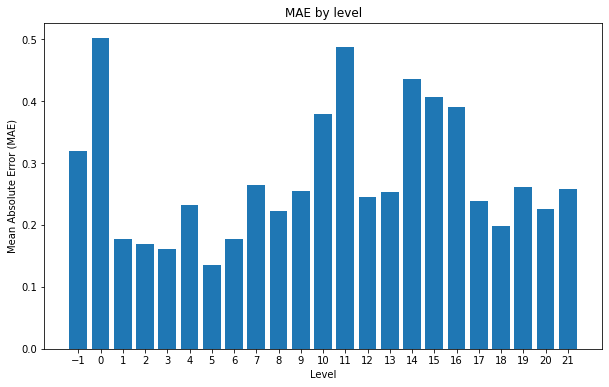

In [42]:
plot_mae_by_level(y_test_random_split, y_pred_test)

In [43]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.03
RMSE: 0.17

Round type: round
MSE: 0.04
RMSE: 0.19

Round type: 0.33
MSE: 0.05
RMSE: 0.22

Round type: 0.45
MSE: 0.04
RMSE: 0.21



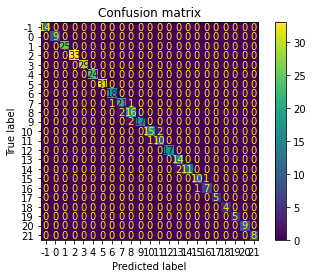

In [44]:
plot_confusion_matrix("round", predict, y_test)

## Summary

In [45]:
results

,Split type,Tuning type,Number of characteristics,MSE,RMSE,MAE
0,chronological,normal,50,0.927292,0.962960,0.460853
1,chronological,Optuna,50,0.401520,0.633656,0.367590
2,random,normal,50,0.137900,0.371349,0.246737
3,random,Optuna,50,0.090469,0.300781,0.216199


In [46]:
from training.results import plot_summary

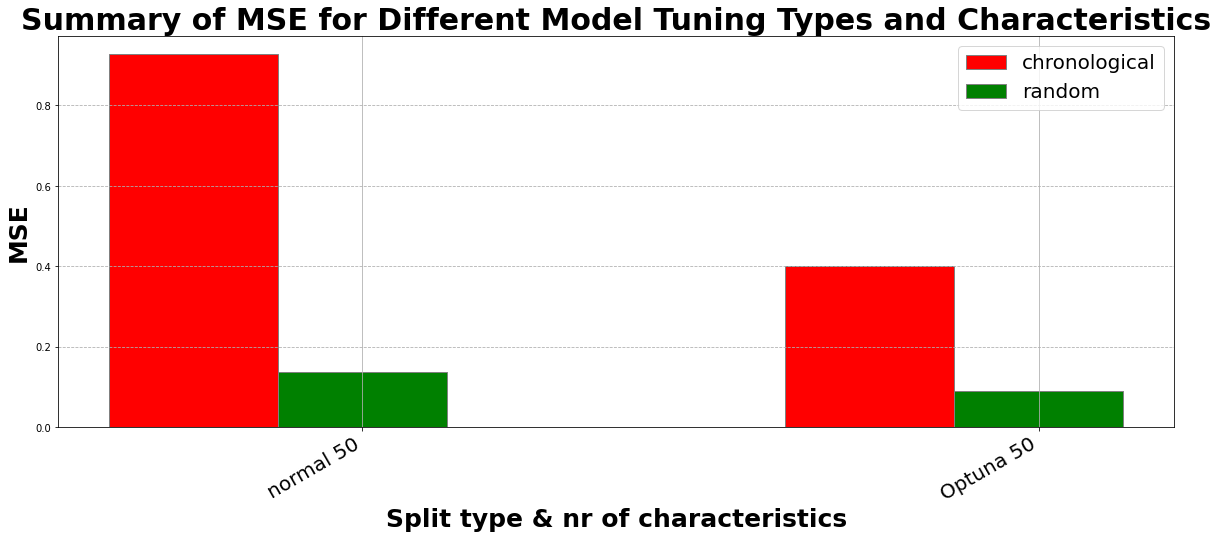

In [47]:
plot_summary(results, "MSE")

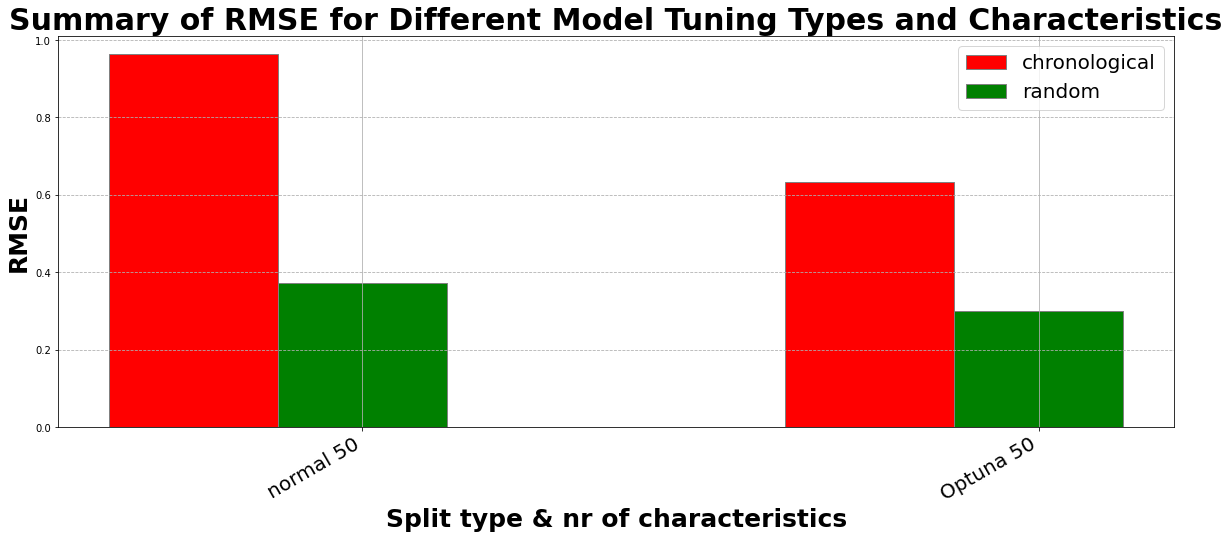

In [48]:
plot_summary(results, "RMSE")

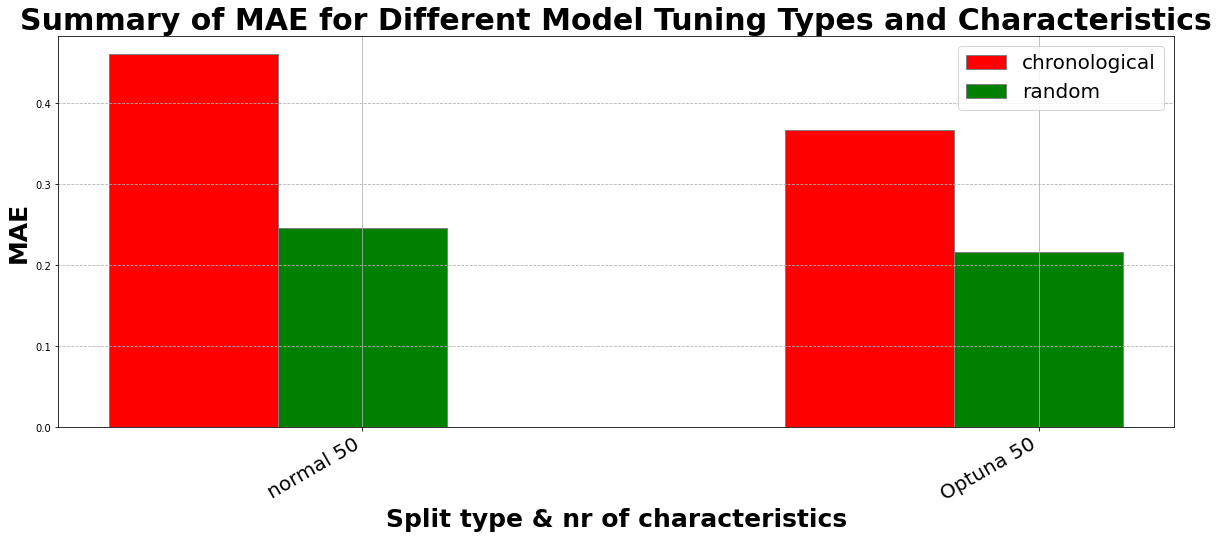

In [49]:
plot_summary(results, "MAE")

In [50]:
results.to_json("./lightgbm_final_results.json")